In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Read data from sensor_17_combined_data.xlsx
df = pd.read_excel('data/sensor_17_combined_data.xlsx')

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData info:")
print(df.info())


Data shape: (11561, 6)
Columns: ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'sensor_id', 'power_W']

First few rows:
             datetime  upper_temp_C  upper_humidity  upper_irradiance  \
0 2025-08-12 17:10:00     34.014333       50.113200      17820.453506   
1 2025-08-12 17:20:00     33.842962       49.132213      17052.397240   
2 2025-08-12 17:30:00     33.201531       52.379251      10387.337372   
3 2025-08-12 17:40:00     31.664925       58.306373      11491.805481   
4 2025-08-12 17:50:00     30.897870       62.023877      12980.730002   

   sensor_id    power_W  
0         17  6508.3320  
1         17  5923.4304  
2         17   927.4650  
3         17   937.6218  
4         17  4106.7306  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11561 entries, 0 to 11560
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          11561 non-null

In [9]:
# Ensure datetime is datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Check for missing values
print("Missing values:")
print(df[['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']].isnull().sum())


Missing values:
datetime            0
upper_temp_C        0
upper_humidity      0
upper_irradiance    0
power_W             0
dtype: int64


In [10]:
# Create cyclical encoding for time features
# Extract hour of day (0-23) and day of year (1-365/366)

# Hour of day (24-hour cycle)
df['hour'] = df['datetime'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Day of year (365-day cycle)
df['day_of_year'] = df['datetime'].dt.dayofyear
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

# Day of week (7-day cycle) - optional but useful
df['day_of_week'] = df['datetime'].dt.dayofweek
df['weekday_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

print("Cyclical time features created:")
print(df[['hour', 'hour_sin', 'hour_cos', 'day_of_year', 'day_sin', 'day_cos', 
          'day_of_week', 'weekday_sin', 'weekday_cos']].head(10))


Cyclical time features created:
   hour  hour_sin      hour_cos  day_of_year  day_sin  day_cos  day_of_week  \
0    17 -0.965926 -2.588190e-01          224 -0.65316 -0.75722            1   
1    17 -0.965926 -2.588190e-01          224 -0.65316 -0.75722            1   
2    17 -0.965926 -2.588190e-01          224 -0.65316 -0.75722            1   
3    17 -0.965926 -2.588190e-01          224 -0.65316 -0.75722            1   
4    17 -0.965926 -2.588190e-01          224 -0.65316 -0.75722            1   
5    18 -1.000000 -1.836970e-16          224 -0.65316 -0.75722            1   
6    18 -1.000000 -1.836970e-16          224 -0.65316 -0.75722            1   
7    18 -1.000000 -1.836970e-16          224 -0.65316 -0.75722            1   
8    18 -1.000000 -1.836970e-16          224 -0.65316 -0.75722            1   
9    18 -1.000000 -1.836970e-16          224 -0.65316 -0.75722            1   

   weekday_sin  weekday_cos  
0     0.781831      0.62349  
1     0.781831      0.62349  
2     0.

In [11]:
# Prepare features and target
# Features: irradiance, temperature, humidity, and cyclical time encoding
features = [
    'upper_irradiance',      # irradiance
    'upper_temp_C',          # temperature
    'upper_humidity',        # humidity
    'hour_sin', 'hour_cos',  # cyclical hour encoding
    'day_sin', 'day_cos',    # cyclical day of year encoding
    'weekday_sin', 'weekday_cos'  # cyclical day of week encoding
]

# Keep datetime for later use
df_clean = df.copy()

# Remove any rows with missing values
mask = ~(df[features].isnull().any(axis=1) | df['power_W'].isnull())
df_clean = df_clean[mask].copy()

X = df_clean[features]
y = df_clean['power_W']
datetimes = df_clean['datetime'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {features}")
print(f"\nDate range: {datetimes.min()} to {datetimes.max()}")
print(f"\nFeature statistics:")
print(X.describe())
print(f"\nTarget statistics:")
print(y.describe())


Features shape: (11561, 9)
Target shape: (11561,)

Features used: ['upper_irradiance', 'upper_temp_C', 'upper_humidity', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos']

Date range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00

Feature statistics:
       upper_irradiance  upper_temp_C  upper_humidity      hour_sin  \
count      11561.000000  11561.000000    11561.000000  11561.000000   
mean        5919.722242     18.505759       70.705479     -0.002648   
std         7651.173132      8.028328       19.111516      0.707448   
min            0.000000     -1.711833       23.473927     -1.000000   
25%            0.000000     12.959433       54.777133     -0.707107   
50%          306.837817     18.045750       73.404750      0.000000   
75%        12635.052969     24.203344       88.280650      0.707107   
max        28825.203128     38.499717       99.819001      1.000000   

           hour_cos       day_sin       day_cos   weekday_sin   weekday_cos  
count  1

In [12]:
# Split data: September as test set, rest as training set
# Get month from datetime
df_clean['month'] = datetimes.dt.month

# September (month 9) as test set
test_mask = df_clean['month'] == 9
train_mask = ~test_mask

X_train = X[train_mask].copy()
X_test = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test = y[test_mask].copy()
datetime_train = datetimes[train_mask].copy()
datetime_test = datetimes[test_mask].copy()

print(f"Training set: {X_train.shape[0]} samples")
print(f"  Date range: {datetime_train.min()} to {datetime_train.max()}")
print(f"Test set (September): {X_test.shape[0]} samples")
print(f"  Date range: {datetime_test.min()} to {datetime_test.max()}")


Training set: 7241 samples
  Date range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00
Test set (September): 4320 samples
  Date range: 2025-09-01 00:00:00 to 2025-09-30 23:50:00


In [13]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model trained successfully!")
print(f"\nCoefficients:")
for feature, coef in zip(features, model.coef_):
    print(f"  {feature}: {coef:.4f}")
print(f"\nIntercept: {model.intercept_:.4f}")


Model trained successfully!

Coefficients:
  upper_irradiance: 0.2523
  upper_temp_C: -19.6142
  upper_humidity: -26.2385
  hour_sin: 468.5271
  hour_cos: -135.8254
  day_sin: 951.9854
  day_cos: -749.7776
  weekday_sin: 101.6445
  weekday_cos: 4.6879

Intercept: 3303.8275


In [14]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Model Performance:")
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f} W")
print(f"  MAE: {train_mae:.4f} W")
print(f"  R²: {train_r2:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f} W")
print(f"  MAE: {test_mae:.4f} W")
print(f"  R²: {test_r2:.4f}")


Model Performance:

Training Set:
  RMSE: 1034.6855 W
  MAE: 714.5777 W
  R²: 0.8254

Test Set:
  RMSE: 1079.0991 W
  MAE: 717.0199 W
  R²: 0.8115


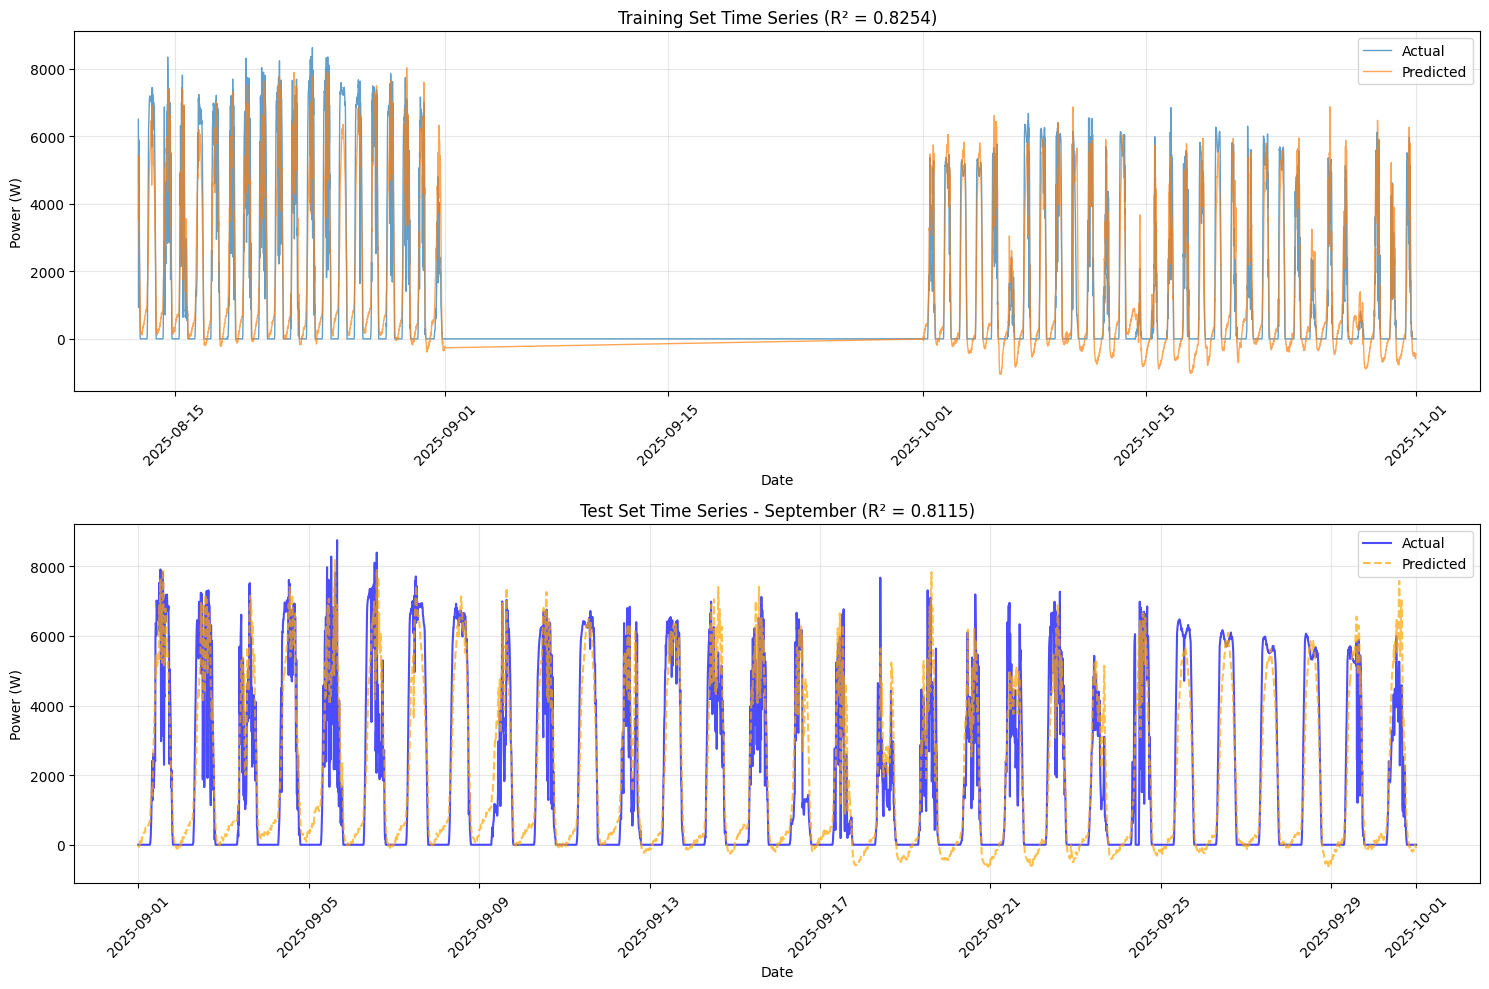

In [15]:
# Visualize predictions vs actual values as time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Sort by datetime for proper time series plotting
train_sorted_idx = datetime_train.argsort()
test_sorted_idx = datetime_test.argsort()

# Training set time series
axes[0].plot(datetime_train.iloc[train_sorted_idx], y_train.iloc[train_sorted_idx], 
             label='Actual', alpha=0.7, linewidth=1)
axes[0].plot(datetime_train.iloc[train_sorted_idx], y_train_pred[train_sorted_idx], 
             label='Predicted', alpha=0.7, linewidth=1)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Power (W)')
axes[0].set_title(f'Training Set Time Series (R² = {train_r2:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Test set time series (September)
axes[1].plot(datetime_test.iloc[test_sorted_idx], y_test.iloc[test_sorted_idx], 
             label='Actual', alpha=0.7, linewidth=1.5, color='blue')
axes[1].plot(datetime_test.iloc[test_sorted_idx], y_test_pred[test_sorted_idx], 
             label='Predicted', alpha=0.7, linewidth=1.5, color='orange', linestyle='--')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Power (W)')
axes[1].set_title(f'Test Set Time Series - September (R² = {test_r2:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [18]:
# Save the trained model and feature list
model_filename = 'sensor_17_linear_regression_model.pkl'
features_filename = 'sensor_17_model_features.pkl'

joblib.dump(model, model_filename)
joblib.dump(features, features_filename)

print(f"Model saved to: {model_filename}")
print(f"Features list saved to: {features_filename}")
print(f"\nModel details:")
print(f"  Number of features: {len(features)}")
print(f"  Features: {features}")


Model saved to: sensor_17_linear_regression_model.pkl
Features list saved to: sensor_17_model_features.pkl

Model details:
  Number of features: 9
  Features: ['upper_irradiance', 'upper_temp_C', 'upper_humidity', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos']


In [19]:
# Load sensor_20 data for testing
df_20 = pd.read_excel('data/sensor_20_combined_data.xlsx')

print("Sensor 20 data:")
print(f"  Shape: {df_20.shape}")
print(f"  Columns: {df_20.columns.tolist()}")
print(f"  Date range: {df_20['datetime'].min()} to {df_20['datetime'].max()}")
print(f"\nFirst few rows:")
print(df_20.head())

# Ensure datetime is datetime type
df_20['datetime'] = pd.to_datetime(df_20['datetime'])

# Check for missing values
print("\nMissing values:")
print(df_20[['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']].isnull().sum())


Sensor 20 data:
  Shape: (10553, 6)
  Columns: ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'sensor_id', 'power_W']
  Date range: 2025-08-19 17:10:00 to 2025-10-31 23:50:00

First few rows:
             datetime  upper_temp_C  upper_humidity  upper_irradiance  \
0 2025-08-19 17:10:00     33.372080       56.480183      15413.131339   
1 2025-08-19 17:20:00     32.911531       55.815923      12027.337390   
2 2025-08-19 17:30:00     32.675092       58.550399      15851.472453   
3 2025-08-19 17:40:00     32.928968       55.992912      14265.380739   
4 2025-08-19 17:50:00     33.113727       54.907654      12273.472250   

   sensor_id    power_W  
0         20  5280.4055  
1         20  1209.5811  
2         20  6394.4196  
3         20  6228.9250  
4         20  5970.6603  

Missing values:
datetime            0
upper_temp_C        0
upper_humidity      0
upper_irradiance    0
power_W             0
dtype: int64


In [20]:
# Apply the same cyclical encoding for time features on sensor_20 data
# Hour of day (24-hour cycle)
df_20['hour'] = df_20['datetime'].dt.hour
df_20['hour_sin'] = np.sin(2 * np.pi * df_20['hour'] / 24)
df_20['hour_cos'] = np.cos(2 * np.pi * df_20['hour'] / 24)

# Day of year (365-day cycle)
df_20['day_of_year'] = df_20['datetime'].dt.dayofyear
df_20['day_sin'] = np.sin(2 * np.pi * df_20['day_of_year'] / 365.25)
df_20['day_cos'] = np.cos(2 * np.pi * df_20['day_of_year'] / 365.25)

# Day of week (7-day cycle)
df_20['day_of_week'] = df_20['datetime'].dt.dayofweek
df_20['weekday_sin'] = np.sin(2 * np.pi * df_20['day_of_week'] / 7)
df_20['weekday_cos'] = np.cos(2 * np.pi * df_20['day_of_week'] / 7)

print("Cyclical time features created for sensor_20")


Cyclical time features created for sensor_20


In [21]:
# Prepare features for sensor_20 using the same feature list
# Remove any rows with missing values
mask_20 = ~(df_20[features].isnull().any(axis=1) | df_20['power_W'].isnull())
df_20_clean = df_20[mask_20].copy()

X_20 = df_20_clean[features]
y_20 = df_20_clean['power_W']
datetime_20 = df_20_clean['datetime'].copy()

print(f"Sensor 20 data shape: {X_20.shape}")
print(f"  Date range: {datetime_20.min()} to {datetime_20.max()}")
print(f"  Features: {features}")
print(f"\nFeature statistics for sensor_20:")
print(X_20.describe())
print(f"\nTarget statistics for sensor_20:")
print(y_20.describe())


Sensor 20 data shape: (10553, 9)
  Date range: 2025-08-19 17:10:00 to 2025-10-31 23:50:00
  Features: ['upper_irradiance', 'upper_temp_C', 'upper_humidity', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos']

Feature statistics for sensor_20:
       upper_irradiance  upper_temp_C  upper_humidity      hour_sin  \
count      10553.000000  10553.000000    10553.000000  10553.000000   
mean        4959.440460     17.761929       71.058042     -0.002901   
std         6533.625254      7.877585       20.088441      0.707480   
min            0.000000     -1.733827       22.945474     -1.000000   
25%            0.000000     12.329517       53.463544     -0.707107   
50%          142.507957     17.410799       74.507388      0.000000   
75%        10695.643641     23.305225       89.773378      0.707107   
max        25679.790707     38.542845       99.836705      1.000000   

           hour_cos       day_sin       day_cos   weekday_sin   weekday_cos  
count  1.05530

In [22]:
# Load the saved model and make predictions on sensor_20
loaded_model = joblib.load(model_filename)
loaded_features = joblib.load(features_filename)

print(f"Model loaded from: {model_filename}")
print(f"Features list loaded: {loaded_features}")

# Make predictions on sensor_20
y_20_pred = loaded_model.predict(X_20)

print(f"\nPredictions made on {len(y_20_pred)} samples from sensor_20")


Model loaded from: sensor_17_linear_regression_model.pkl
Features list loaded: ['upper_irradiance', 'upper_temp_C', 'upper_humidity', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos']

Predictions made on 10553 samples from sensor_20


In [23]:
# Evaluate model performance on sensor_20 (test set)
mse_20 = mean_squared_error(y_20, y_20_pred)
rmse_20 = np.sqrt(mse_20)
mae_20 = mean_absolute_error(y_20, y_20_pred)
r2_20 = r2_score(y_20, y_20_pred)

print("Model Performance on Sensor 20 (Test Set):")
print(f"  RMSE: {rmse_20:.4f} W")
print(f"  MAE: {mae_20:.4f} W")
print(f"  R²: {r2_20:.4f}")
print(f"\nNumber of samples: {len(y_20)}")


Model Performance on Sensor 20 (Test Set):
  RMSE: 1097.0742 W
  MAE: 744.2187 W
  R²: 0.8031

Number of samples: 10553


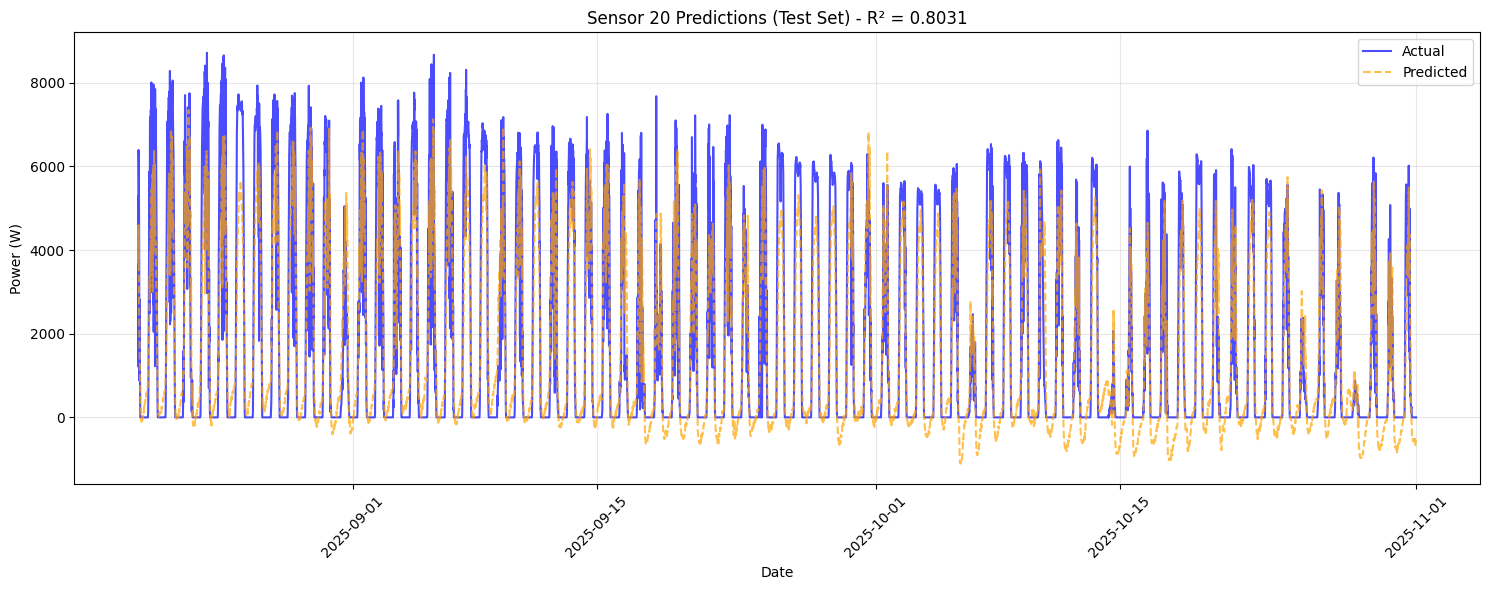

In [24]:
# Visualize predictions vs actual values for sensor_20 as time series
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Sort by datetime for proper time series plotting
sorted_idx_20 = datetime_20.argsort()

# Plot actual vs predicted for sensor_20
ax.plot(datetime_20.iloc[sorted_idx_20], y_20.iloc[sorted_idx_20], 
        label='Actual', alpha=0.7, linewidth=1.5, color='blue')
ax.plot(datetime_20.iloc[sorted_idx_20], y_20_pred[sorted_idx_20], 
        label='Predicted', alpha=0.7, linewidth=1.5, color='orange', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Power (W)')
ax.set_title(f'Sensor 20 Predictions (Test Set) - R² = {r2_20:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [25]:
# Calculate residuals (Panel 20 Effect)
# Residual = Actual - Predicted
# Positive residual means sensor_20 produces more power than predicted (trained on sensor_17)
# Negative residual means sensor_20 produces less power than predicted
residuals_20 = y_20 - y_20_pred

print("Residual Analysis (Panel 20 Effect):")
print(f"  Mean residual: {residuals_20.mean():.4f} W")
print(f"  Median residual: {residuals_20.median():.4f} W")
print(f"  Std deviation: {residuals_20.std():.4f} W")
print(f"  Min residual: {residuals_20.min():.4f} W")
print(f"  Max residual: {residuals_20.max():.4f} W")
print(f"\nInterpretation:")
if residuals_20.mean() > 0:
    print(f"  On average, Sensor 20 produces {residuals_20.mean():.2f} W MORE power than predicted")
    print(f"  (Sensor 20 is more efficient/has higher output than Sensor 17)")
else:
    print(f"  On average, Sensor 20 produces {abs(residuals_20.mean()):.2f} W LESS power than predicted")
    print(f"  (Sensor 20 is less efficient/has lower output than Sensor 17)")


Residual Analysis (Panel 20 Effect):
  Mean residual: 217.5098 W
  Median residual: 54.9137 W
  Std deviation: 1075.3469 W
  Min residual: -5386.0221 W
  Max residual: 5449.6833 W

Interpretation:
  On average, Sensor 20 produces 217.51 W MORE power than predicted
  (Sensor 20 is more efficient/has higher output than Sensor 17)


In [29]:
# Summary statistics by time periods
print("Residual Statistics by Time Period:")
print("=" * 50)

# Convert residuals to array for DataFrame
residuals_array = np.array(residuals_20)

# Create a DataFrame with residuals and datetime for easier analysis
residuals_df = pd.DataFrame({
    'datetime': datetime_20,
    'residual': residuals_array,
    'hour': datetime_20.dt.hour,
    'day_of_week': datetime_20.dt.dayofweek,
    'month': datetime_20.dt.month
})

# By hour of day
print("\nAverage Residual by Hour of Day:")
hourly_stats = residuals_df.groupby('hour')['residual'].agg(['mean', 'std', 'count'])
print(hourly_stats.head(10))
print("...")

# By day of week
print("\nAverage Residual by Day of Week (0=Monday, 6=Sunday):")
daily_stats = residuals_df.groupby('day_of_week')['residual'].agg(['mean', 'std', 'count'])
print(daily_stats)

# Overall summary
print(f"\nOverall Summary:")
print(f"  Total samples: {len(residuals_array)}")
print(f"  Mean residual: {residuals_array.mean():.2f} W")
print(f"  Std residual: {residuals_array.std():.2f} W")
print(f"  RMSE: {rmse_20:.2f} W")
print(f"  MAE: {mae_20:.2f} W")


Residual Statistics by Time Period:

Average Residual by Hour of Day:
             mean          std  count
hour                                 
0      133.241922   297.333684    438
1       25.181963   291.630881    438
2      -74.893084   285.104198    438
3     -169.196708   289.553537    438
4     -253.970946   285.778704    438
5     -317.700750   279.196419    438
6     -373.817155   299.749666    438
7     -163.447780   487.885640    438
8      962.630835  1292.590081    438
9     1471.179443  1724.716086    438
...

Average Residual by Day of Week (0=Monday, 6=Sunday):
                   mean          std  count
day_of_week                                
0            265.982383  1055.913085   1440
1             -0.557414  1018.635522   1481
2            110.287887  1103.118948   1584
3            385.946861  1016.847936   1584
4            101.013356  1105.749480   1584
5            388.366034  1075.844012   1440
6            283.266470  1084.047604   1440

Overall Summary:
 

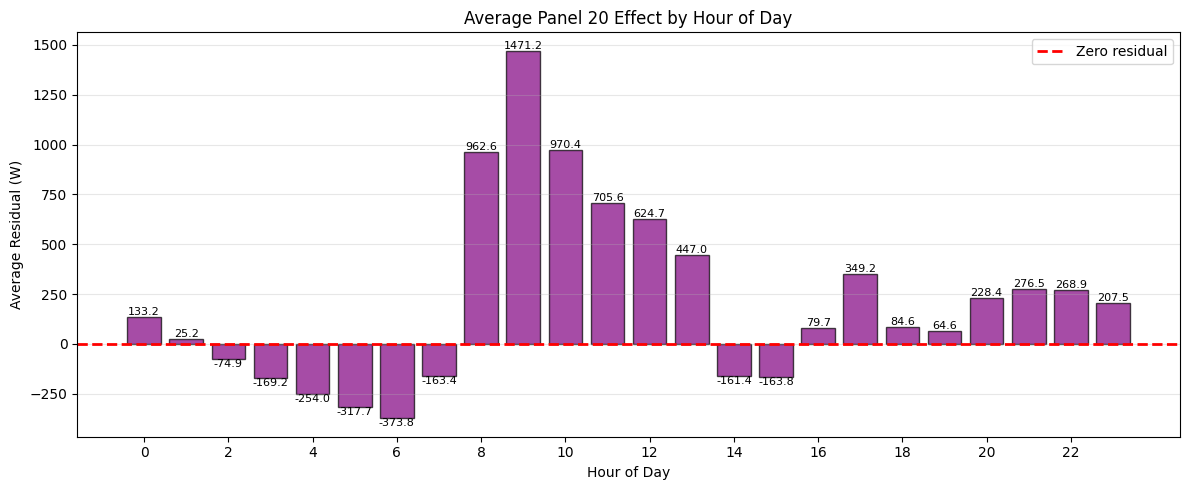

In [30]:
# Visualize average residuals by hour of day
hourly_residuals = residuals_df.groupby('hour')['residual'].mean()

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

bars = ax.bar(hourly_residuals.index, hourly_residuals.values, 
              alpha=0.7, color='purple', edgecolor='black')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero residual')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Residual (W)')
ax.set_title('Average Panel 20 Effect by Hour of Day')
ax.set_xticks(range(0, 24, 2))
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()
